In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sys, os
scr_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(scr_dir)


from load import TimeSeriesLoader
import warnings
warnings.filterwarnings('ignore')
# import preprocessing
from preprocess import (
    create_rolling_ts, 
    split_data, 
    flatten
)

from error_metrics import regression_metrics


## Import data from archive

In [2]:
ROOT_PATH = 'C://Users/gilbe/Documents/aifi-bootcamp'
df = pd.read_csv(f'{ROOT_PATH}/data/aapl.csv')
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('Date', inplace=True)
# df.rename(columns={'Unnamed: 0', 'Date'}, inplace=True)
df.head()

,1. open,2. high,3. low,4. close,5. volume
Date,,,,,
2022-01-24 04:05:00,162.0632,162.9520,162.0632,162.6025,10936.0
2022-01-24 04:10:00,162.7423,162.9620,162.6225,162.9620,7705.0
2022-01-24 04:15:00,162.7922,162.7922,162.5925,162.7623,7305.0
2022-01-24 04:20:00,162.6924,162.7223,162.3928,162.4627,9290.0
2022-01-24 04:25:00,162.3129,162.4826,162.2729,162.4327,6117.0


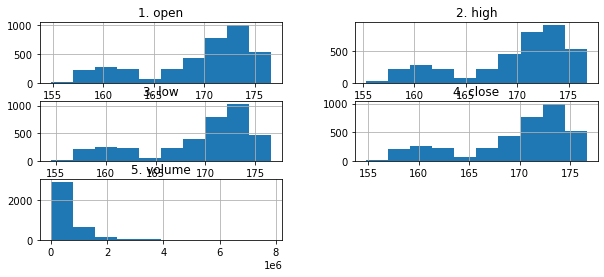

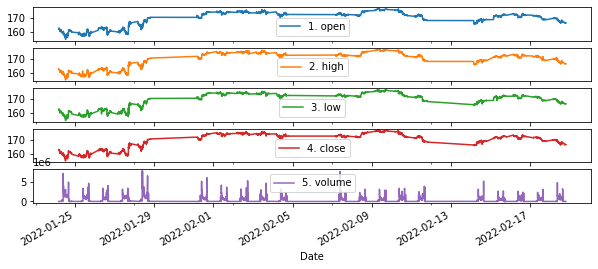

In [3]:
df.hist(figsize=(10, 4));
df.plot(figsize=(10, 4), subplots=True);

# Create train-val-test

In [4]:
data_train, data_val, data_test = split_data(df[['4. close']], train_size=.75, valid_size=.125)

xtrain, ytrain = create_rolling_ts(input_data=data_train, lookback=30, return_np_array=True)
xval, yval = create_rolling_ts(input_data=data_val, lookback=30, return_np_array=True)
xtest, ytest = create_rolling_ts(input_data=data_test, lookback=30, return_np_array=True)


# Flatten data to N X 1 dimensions
xtrain, ytrain = flatten(xtrain), flatten(ytrain)
xval, yval = flatten(xval), flatten(yval)
xtest, ytest = flatten(xtest), flatten(ytest)

In [5]:
xtrain.shape, ytrain.shape

((2793, 150), (2793, 1))

In [6]:
xtrain.reshape(xtrain.shape[0], -1).shape, ytrain.reshape(ytrain.shape[0], -1).shape

((2793, 150), (2793, 1))

In [7]:
# xt, yt = train_test_split(data_train, 30)

In [8]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=800, 
    max_depth=5
)


regressor.fit(xtrain.reshape(xtrain.shape[0], -1), ytrain.reshape(ytrain.shape[0], -1))



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

mse-train: 2.488371212924332e-06 mse-val: 0.18404561303593464
r2-train: 0.9999999305244845 r2-val: 0.9523930392936718
smape-train: 0.01893041899724728 smape-val: 0.006467287502034367


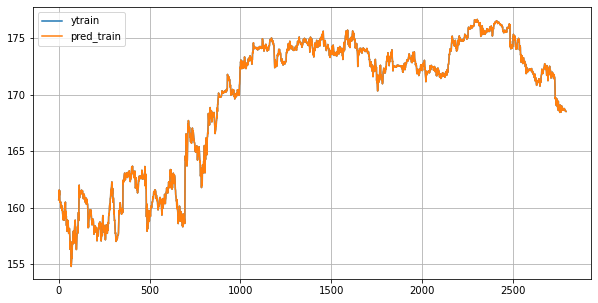

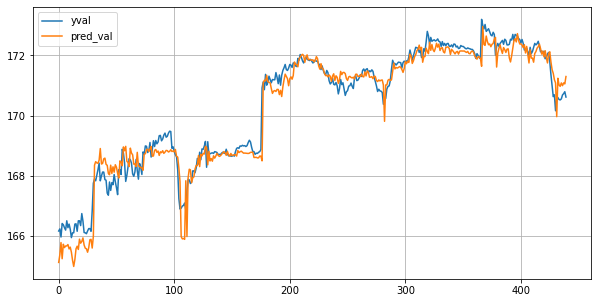

In [25]:
pred_train = regressor.predict(xtrain)
pred_val = regressor.predict(xval)
mse_train, r2_train, mae_train, smape_train = regression_metrics(ytrain, pred_train)
mse_val, r2_val, mae_val, smape_val = regression_metrics(yval, pred_val)
print('mse-train:', mse_train, 'mse-val:', mse_val)
print('r2-train:', r2_train, 'r2-val:', r2_val)
print('smape-train:', smape_train, 'smape-val:', smape_val)


df_train = pd.DataFrame(
    {
        'ytrain': ytrain.reshape(-1), 
        'pred_train': pred_train.reshape(-1), 
    }
).plot(figsize=(10, 5), grid=True);

df_train = pd.DataFrame(
    {
         'yval': yval.reshape(-1), 
         'pred_val': pred_val.reshape(-1)
        }
).plot(figsize=(10, 5), grid=True);